In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch import optim
from skorch.regressor import NeuralNetRegressor
from tabularasa.MixedMonotonicNet import MixedMonotonicNet
from tabularasa.OrthonormalCertificates import OrthonormalCertificates
from tabularasa.OrthonormalCertificatesRegressor import OrthonormalCertificatesNet, OrthonormalCertificatesRegressor

In [2]:
df = pd.read_pickle('./examples/data/simple_train.pkl')

In [3]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb1 = nn.Embedding(50, 16)
        self.fc1 = nn.Linear(1 + 16, 16)
    
    def forward(self, X_non_monotonic):
        X = torch.cat([X_non_monotonic[:, 1, None].float(), 
                       self.emb1(X_non_monotonic[:, 0, None].long()).squeeze()], 1)
        return F.relu(self.fc1(X))

In [4]:
model = NeuralNetRegressor(MixedMonotonicNet,
                           max_epochs=25,
                           lr=0.001,
                           optimizer=torch.optim.Adam,
                           iterator_train__shuffle=True,
                           module__non_monotonic_net=EmbeddingNet(),
                           module__dim_non_monotonic=16,
                           module__dim_monotonic=2,
                           module__layers=[128, 128, 32],
                           module__integration_steps=300)

In [5]:
model.fit({'X_monotonic': df[['x1', 'x2']].values,
           'X_non_monotonic': df[['x3', 'x4']].values},
          df[['y']].values)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.6202        0.4216  8.4407
      2        0.3595        0.2965  8.3669
      3        0.3143        0.2931  8.1897
      4        0.3018        0.2932  8.1326
      5        0.2945        0.2842  8.1868
      6        0.2884        0.2777  8.2577
      7        0.2805        0.2716  8.2155


<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=MixedMonotonicNet(
    (non_monotonic_net): EmbeddingNet(
      (emb1): Embedding(50, 16)
      (fc1): Linear(in_features=17, out_features=16, bias=True)
    )
    (umnn): SlowDMonotonicNN(
      (outer_net): MonotonicNN(
        (integrand): IntegrandNN(
          (inner_net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
          )
          (net): Sequential(
            (0): Linear(in_features=17, out_features=128, bias=True)
            (1): ReLU()
            (2): Linear(in_features=128, out_features=128, bias=True)
            (3): ReLU()
            (4): Linear(in_features=128, out_features=32, bias=True)
            (5): ReLU()
            (6): Linear(in_features=32

In [6]:
quantiles = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]

In [7]:
results = []
for q in np.quantile(df['x1'], quantiles):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                       'X_non_monotonic': dfc[['x3', 'x4']].values})
    p = pd.DataFrame(pd.Series(p[:, 0]).describe(percentiles=quantiles)).T
    p['x1'] = q
    results.append(p)
results = pd.concat(results, axis=0)

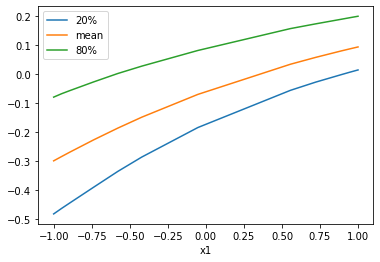

In [8]:
results.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

### Estimate epistemic uncertainty via orthonormal certificates

Start by prepping data from the inner hidden layer.

In [9]:
model.module_.set_last_layer(inner=True)

In [10]:
X_inner = model.predict({'X_monotonic': df[['x1', 'x2']].values,
                         'X_non_monotonic': df[['x3', 'x4']].values})

In [11]:
ocr = OrthonormalCertificatesRegressor(OrthonormalCertificatesNet,
                                       max_epochs=500,
                                       lr=0.01,
                                       optimizer=torch.optim.Adam,
                                       iterator_train__shuffle=True,
                                       module__dim_input=32)

In [12]:
ocr.fit(X_inner)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1        0.1652        0.0864  0.0974
      2        0.0528        0.0396  0.0710
      3        0.0282        0.0238  0.0555
      4        0.0180        0.0162  0.0547
      5        0.0138        0.0127  0.0564
      6        0.0119        0.0112  0.0543
      7        0.0110        0.0107  0.0573
      8        0.0106        0.0104  0.0557
      9        0.0104        0.0103  0.0576
     10        0.0102        0.0101  0.0580
     11        0.0102        0.0100  0.0585
     12        0.0101        0.0100  0.0812
     13        0.0100        0.0099  0.0814
     14        0.0099        0.0098  0.0867
     15        0.0099        0.0098  0.0894
     16        0.0098        0.0097  0.0829
     17        0.0097        0.0096  0.0859
     18        0.0097        0.0096  0.0866
     19        0.0096        0.0095  0.0897
     20        0.0095        0.0095  0.0853
     21        0.0095        0.0

    162        0.0086        0.0086  0.0719
    163        0.0086        0.0085  0.0500
    164        0.0086        0.0086  0.0507
    165        0.0086        0.0085  0.0483
    166        0.0086        0.0085  0.0482
    167        0.0086        0.0086  0.0479
    168        0.0087        0.0086  0.0477
    169        0.0086        0.0086  0.0492
    170        0.0086        0.0086  0.0569
    171        0.0086        0.0086  0.0753
    172        0.0086        0.0086  0.0756
    173        0.0086        0.0086  0.0786
    174        0.0086        0.0086  0.0787
    175        0.0086        0.0085  0.0796
    176        0.0086        0.0085  0.0854
    177        0.0086        0.0086  0.0837
    178        0.0086        0.0085  0.0861
    179        0.0086        0.0085  0.0817
    180        0.0086        0.0085  0.0847
    181        0.0086        0.0085  0.0852
    182        0.0086        0.0086  0.0915
    183        0.0086        0.0085  0.0540
    184        0.0086        0.0

    344        0.0085        0.0084  0.0557
    345        0.0085        0.0084  0.0497
    346        0.0085        0.0085  0.0512
    347        0.0085        0.0084  0.0525
    348        0.0085        0.0083  0.0502
    349        0.0084        0.0083  0.0512
    350        0.0085        0.0084  0.0498
    351        0.0085        0.0084  0.0506
    352        0.0085        0.0085  0.0496
    353        0.0085        0.0085  0.0509
    354        0.0085        0.0084  0.0526
    355        0.0085        0.0084  0.0524
    356        0.0085        0.0085  0.0484
    357        0.0085        0.0084  0.0545
    358        0.0085        0.0084  0.0490
    359        0.0084        0.0083  0.0497
    360        0.0085        0.0084  0.0490
    361        0.0085        0.0085  0.0490
    362        0.0086        0.0084  0.0491
    363        0.0085        0.0084  0.0528
    364        0.0085        0.0087  0.0499
    365        0.0085        0.0085  0.0505
    366        0.0085        0.0

<class 'tabularasa.OrthonormalCertificatesRegressor.OrthonormalCertificatesRegressor'>[initialized](
  module_=OrthonormalCertificatesNet(
    (certificates): Linear(in_features=32, out_features=64, bias=True)
  ),
)

In [13]:
ocr.predict(X_inner)

array([0.00031503, 0.00044481, 0.00039357, ..., 0.0003259 , 0.00037354,
       0.00048632], dtype=float32)

Now train orthonormal certificates.  Note, including raw numeric features helps quality.

In [24]:
oc = OrthonormalCertificates()
oc.fit(np.concatenate([df[['x1', 'x2', 'x4']].values, X_inner], axis=1))

Create another PDP like dataset with the full range.

In [31]:
uncertainties = []
for q in np.linspace(-1.5, 1.5, 101):
    dfc = df.copy()
    dfc['x1'] = q
    dfc['x1'] = dfc['x1'].astype('float32')
    p = oc.transform(np.concatenate([dfc[['x1', 'x2', 'x4']],
                                     model.predict({'X_monotonic': dfc[['x1', 'x2']].values,
                                                    'X_non_monotonic': dfc[['x3', 'x4']].values})], axis=1))
    p = pd.DataFrame(pd.Series(p).describe(percentiles=quantiles)).T
    p['x1'] = q
    uncertainties.append(p)
uncertainties = pd.concat(uncertainties, axis=0)

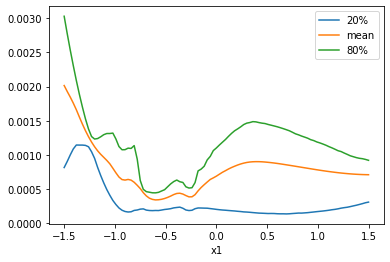

In [32]:
uncertainties.plot(x='x1', y=['20%', 'mean', '80%'])
plt.show()

Epistemic uncertainty is high below -1 (where training data starts and is relatively low), decreases between -1 and 0, picks back up between 0 and 0.5, and then decreases between 0.5 and 1.  After 1, it doesn't perform exactly as desired, but is ticking up in some places.